 ## Defining the problem and assembling a dataset

- German Credit Data
  - https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)
- Binary Classification Problem

 ## Choosing a measure of success

- Balanced Accuracy Score
- Precision and Recall
- AUC

## Deciding on an evaluation protocol

- Maintaining a hold-out validation set
- Doing K-fold cross-validation

## Preparing your data

In [3]:
import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

import itertools
import matplotlib.pyplot as plt

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [7]:
FILE_PATH = 'http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'

HEADERS = ['Status of existing checking account', 'Duration in month', 'Credit history',
           'Purpose','Credit amount', 'Savings account/bonds', 'Present employment since',
           'Installment rate in percentage of disposable income', 'Personal status and sex',
           'Other debtors / guarantors', 'Present residence since', 'Property', 'Age in years',
           'Other installment plans', 'Housing', 'Number of existing credits at this bank',
           'Job', 'Number of people being liable to provide maintenance for', 'Telephone', 'Foreign worker', 
           'Cost Matrix(Risk)']

In [5]:
df = pd.read_csv(FILE_PATH, sep=" ", header=None)
df.columns = HEADERS

df.head()

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,Foreign worker,Cost Matrix(Risk)
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [6]:
NUMERICAL_VARIABLES = ['Duration in month', 'Credit amount', 'Installment rate in percentage of disposable income',
                     'Present residence since', 'Age in years', 'Number of existing credits at this bank', 
                     'Number of people being liable to provide maintenance for']
                     
CATEGORICAL_VARIABLES = ['Status of existing checking account', 'Credit history',
                         'Purpose', 'Savings account/bonds', 'Present employment since',
                         'Personal status and sex', 'Other debtors / guarantors',
                         'Property', 'Other installment plans', 'Housing',
                         'Job', 'Telephone', 'Foreign worker']

In [9]:
features = df[NUMERICAL_VARIABLES + CATEGORICAL_VARIABLES]

In [10]:
TARGET_VARIABLE = 'Cost Matrix(Risk)'

target = df[TARGET_VARIABLE]

In [11]:
TEST_SIZE = 0.1

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=TEST_SIZE, 
                                                    random_state=SEED, shuffle=True, stratify=target.values)

In [12]:
preprocessor = ColumnTransformer([
    ('one-hot-encoder', OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_VARIABLES),
    ('standard_scaler', StandardScaler(), NUMERICAL_VARIABLES)])

_ = preprocessor.fit(X_train)

In [13]:
X_train, X_test = preprocessor.transform(X_train), preprocessor.transform(X_test)

In [14]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [16]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=VALIDATION_SIZE, stratify=y_train,
                                                  shuffle=True, random_state=SEED)

In [17]:
sm = SMOTE(sampling_strategy='auto', random_state=SEED)
Xs, ys = sm.fit_resample(X_train, y_train)

In [18]:
Xs_train, Xs_val, ys_train, ys_val = train_test_split(Xs, ys, test_size=VALIDATION_SIZE, 
                                                      random_state=SEED, shuffle=True, 
                                                      stratify=ys)

##  Developing a model that does better than a baseline

In [19]:
counts = df.groupby([TARGET_VARIABLE])[TARGET_VARIABLE].count()

counts

Cost Matrix(Risk)
1    700
2    300
Name: Cost Matrix(Risk), dtype: int64

In [20]:
baseline = counts.iloc[0] / counts.sum()

baseline

0.7

In [21]:
balanced_accuracy_score(y_train, np.zeros(len(y_train)))

0.5

In [22]:
# MLP Model Instatiation
def deep_neural_network(hidden_layers=0, hidden_neurons=np.nan, activation=None,
                        dropout=np.nan, input_dimension=2, output_dimension=1,
                        optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'],
                        name=None) :
    
    model = Sequential()
    for layer in range(hidden_layers) :
        model.add(Dense(hidden_neurons, 
                  activation=activation, 
                  input_shape='default' if layer>1 else (input_dimension,)))
        if ~np.isnan(dropout) :
            model.add(Dropout(dropout))
        
    model.add(Dense(output_dimension, 
                    activation='sigmoid' if output_dimension==1 else 'softmax',
                    input_shape='default' if hidden_layers>0 else (input_dimension,)))
  
    if name is not None :
        model._name = name
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [24]:
# Fitting MLP Classification Model
def train_deep_neural_network(model, X, y, 
                              batch_size=32, epochs=100, 
                              val_data=None, callbacks=[], seed=0) :
    
    if val_data is None :
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                          random_state=seed, shuffle=True, 
                                                          stratify=y)
        
    else :
        X_train, y_train, X_val, y_val = X, y, val_data[0], val_data[1]
  

    history = model.fit(X_train, y_train,
                        batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_val, y_val),
                        callbacks=callbacks,
                        verbose=0)

    return {'model': model, 
            'val_score': model.evaluate(X_val, y_val, verbose=0)[1:], 
            'history': history }

In [57]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_DIMENSION = 1

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]

In [148]:
slp_model = deep_neural_network(hidden_layers=2, hidden_neurons=8,
                                activation='relu',
                                dropout=0.25,
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_DIMENSION,
                                optimizer=OPTIMIZER, loss=LOSS_FUNC, 
                                metrics=METRICS,
                                name='Single_Layer_Perceptron')

slp_model.summary()

Model: "Single_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_175 (Dense)           (None, 8)                 496       
                                                                 
 dropout_113 (Dropout)       (None, 8)                 0         
                                                                 
 dense_176 (Dense)           (None, 8)                 72        
                                                                 
 dropout_114 (Dropout)       (None, 8)                 0         
                                                                 
 dense_177 (Dense)           (None, 1)                 9         
                                                                 
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [149]:
batch_size = 32
EPOCHS = 100

MONITOR = 'val_loss'
PATIENCE = 5

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

In [150]:
trained_slp_model = train_deep_neural_network(slp_model, Xs_train, ys_train,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(Xs_val, ys_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

In [151]:
print('Accuracy (Balanced Validation): {:.2f} (baseline=0.5)'.format(trained_slp_model['val_score'][0]))
print('Precision (Balanced Validation): {:.2f}'.format(trained_slp_model['val_score'][1]))
print('Recall (Balanced Validation): {:.2f}'.format(trained_slp_model['val_score'][2]))
print('AUC (Balanced Validation): {:.2f}'.format(trained_slp_model['val_score'][3]))

Accuracy (Balanced Validation): 0.80 (baseline=0.5)
Precision (Balanced Validation): 0.80
Recall (Balanced Validation): 0.80
AUC (Balanced Validation): 0.89


In [152]:
preds = trained_slp_model['model'].predict(X_val, verbose=0)

print('Accuracy (Imbalanced Validation): {:.2f} (baseline=0.7)'.format(accuracy_score(y_val, (preds > 0.5).astype('int32'))))
print('Precision (Imbalanced Validation): {:.2f}'.format(precision_score(y_val, (preds > 0.5).astype('int32'))))
print('Recall (Imbalanced Validation): {:.2f}'.format(recall_score(y_val, (preds > 0.5).astype('int32'))))
print('AUC (Imbalanced Validation): {:.2f}'.format(roc_auc_score(y_val, preds)))

Accuracy (Imbalanced Validation): 0.72 (baseline=0.7)
Precision (Imbalanced Validation): 0.53
Recall (Imbalanced Validation): 0.63
AUC (Imbalanced Validation): 0.72


In [153]:
print('Balanced Accuracy (Validation): {:.2f} (baseline = 0.5)'.format(balanced_accuracy_score(y_val, (preds > 0.5).astype('int32'))))

Balanced Accuracy (Validation): 0.70 (baseline = 0.5)


In [154]:
def plot_training_history(history, monitors=['loss', 'AUC']) :

  # using the variable axs for multiple Axes
  fig, axs = plt.subplots(1, 2, sharex='all', figsize=(15,5))
 
  for ax, monitor in zip(axs.flat, monitors) :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    if monitor == 'loss' :
      monitor = monitor.capitalize()

    epochs = range(1, len(loss)+1)

    ax.plot(epochs, loss, 'b.', label=monitor)
    ax.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    ax.set_xlim([0, len(loss)])
    ax.title.set_text('Training and Validation ' + monitor + 's')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(monitor)
    ax.legend()
    ax.grid()

  _ = plt.show()

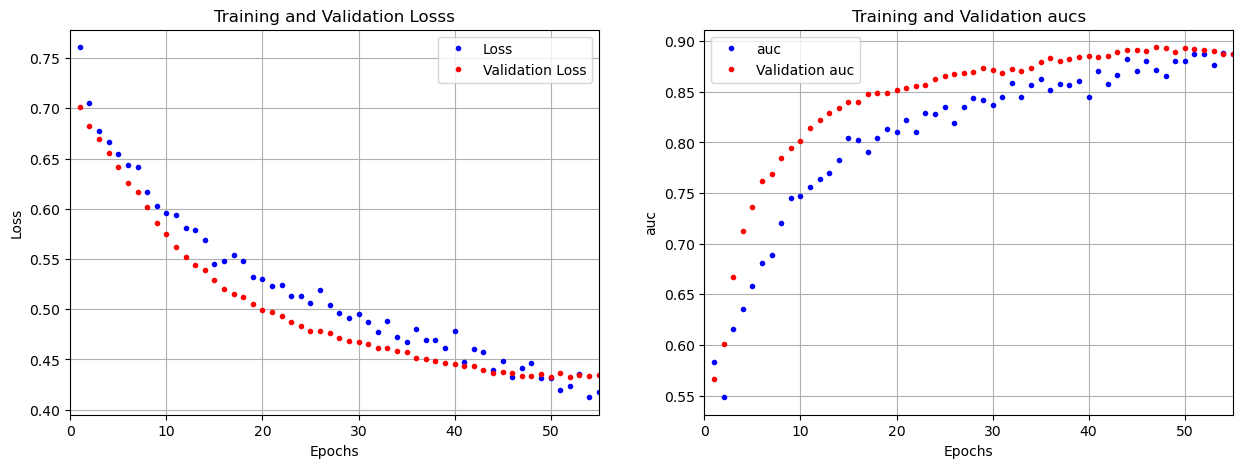

In [155]:
plot_training_history(trained_slp_model['history'], monitors=['loss', 'auc'])

 ## Scaling up: developing a model that overfits

In [156]:
mlp_model = deep_neural_network(hidden_layers=3, hidden_neurons=8,
                                activation='relu',
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_DIMENSION,
                                optimizer=OPTIMIZER, loss=LOSS_FUNC, 
                                metrics=METRICS,
                                name='Multi_Layer_Perceptron')

mlp_model.summary()

Model: "Multi_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_178 (Dense)           (None, 8)                 496       
                                                                 
 dense_179 (Dense)           (None, 8)                 72        
                                                                 
 dense_180 (Dense)           (None, 8)                 72        
                                                                 
 dense_181 (Dense)           (None, 1)                 9         
                                                                 
Total params: 649
Trainable params: 649
Non-trainable params: 0
_________________________________________________________________


In [157]:
trained_mlp_model = train_deep_neural_network(mlp_model, Xs_train, ys_train,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(Xs_val, ys_val), 
                                              callbacks=[], seed=SEED)

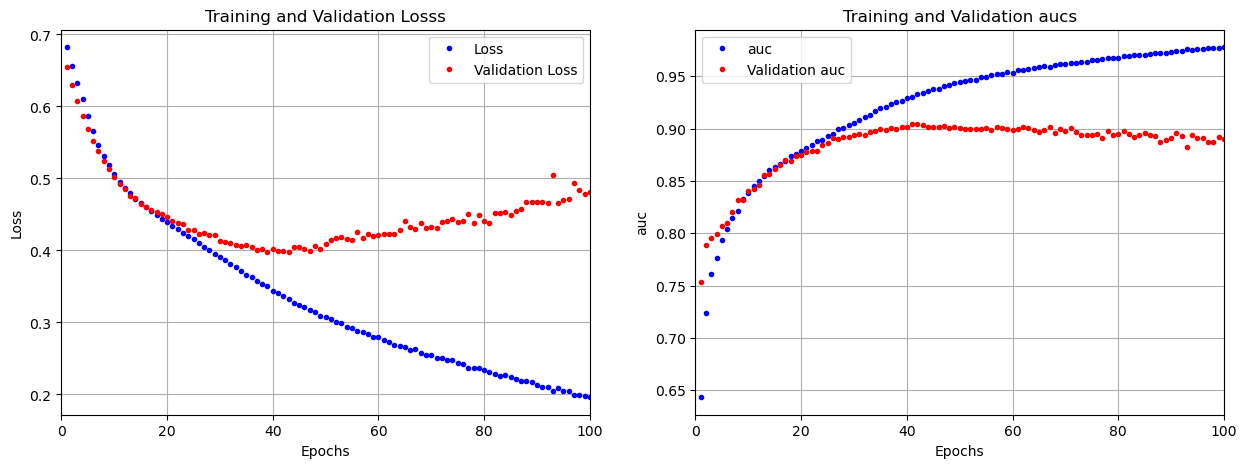

In [158]:
plot_training_history(trained_mlp_model['history'], monitors=['loss', 'auc'])

In [182]:
print('Accuracy (Balanced Validation): {:.2f} (baseline=0.5)'.format(trained_mlp_model['val_score'][0]))
print('Precision (Balanced Validation): {:.2f}'.format(trained_mlp_model['val_score'][1]))
print('Recall (Balanced Validation): {:.2f}'.format(trained_mlp_model['val_score'][2]))
print('AUC (Balanced Validation): {:.2f}'.format(trained_mlp_model['val_score'][3]))

Accuracy (Balanced Validation): 0.80 (baseline=0.5)
Precision (Balanced Validation): 0.79
Recall (Balanced Validation): 0.82
AUC (Balanced Validation): 0.89


In [160]:
preds = trained_mlp_model['model'].predict(X_val, verbose=0)

print('Accuracy (Imbalanced Validation): {:.2f} (baseline=0.7)'.format(accuracy_score(y_val, (preds > 0.5).astype('int32'))))
print('Precision (Imbalanced Validation): {:.2f}'.format(precision_score(y_val, (preds > 0.5).astype('int32'))))
print('Recall (Imbalanced Validation): {:.2f}'.format(recall_score(y_val, (preds > 0.5).astype('int32'))))
print('AUC (Imbalanced Validation): {:.2f}'.format(roc_auc_score(y_val, preds)))
print('Balanced Accuracy (Validation): {:.2f} (baseline = 0.5)'.format(balanced_accuracy_score(y_val, (preds > 0.5).astype('int32'))))

Accuracy (Imbalanced Validation): 0.67 (baseline=0.7)
Precision (Imbalanced Validation): 0.46
Recall (Imbalanced Validation): 0.63
AUC (Imbalanced Validation): 0.67
Balanced Accuracy (Validation): 0.66 (baseline = 0.5)


 ## Regularizing your model and tuning your hyperparameters

In [161]:
# Reformat Grid CV Stats to Dataframe
def to_dataframe(stats, mapping) :
    entries = []
    for param, metrics in stats.items() :
        entry = eval(param)
        for key, value in metrics.items() :
            entry[key] = value
        
        for key, value in mapping.items() :
            entry[value] = entry['scores'][key]
            
        entry.pop('scores') 
        
        entries.append( entry )

    return pd.DataFrame(data=entries)

In [162]:
# Grid Search CV
def grid_search_cv(X, y,
                   space, cv, 
                   optimizer, loss, metrics, 
                   epochs, callbacks=[], seed=0,
                   addon_metrics={}, order={}) :
    
    keys, values = zip(*space.items())
    
    stats = {}
    for params in [dict(zip(keys, v)) for v in itertools.product(*values)] :
        kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)
        
        scores, stopped, losses = [], [], []
        for train, validate in kfold.split(X, y) :
            model = deep_neural_network(hidden_layers=params['hidden_layers'], 
                                        hidden_neurons=params['neurons'], 
                                        activation=params['activation'], 
                                        dropout=params['dropout'], 
                                        input_dimension=X.shape[1], 
                                        output_dimension=1 if len(y.shape)<2 else y.shape[1],
                                        optimizer=optimizer, loss=loss, 
                                        metrics=metrics)
      
            trained = train_deep_neural_network(model, 
                                                X[train,:], y[train], 
                                                batch_size=params['batch_size'], epochs=epochs, 
                                                val_data=(X[validate,:], y[validate]), 
                                                callbacks=callbacks, seed=seed) 
            
            evaluations = trained['model'].evaluate(X[validate,:], y[validate], verbose=0)[1:]
            for key, value in addon_metrics.items() :
                preds = (trained['model'].predict(X[validate,:], verbose=0) > 0.5).astype('int32')
                evaluations.append( value(y[validate], preds) )
                        
            scores.append( evaluations )
            stopped.append( len(trained['history'].history['val_loss']) )
            losses.append( np.min(trained['history'].history['val_loss']) )
        
        stats[str(params)] = { 'scores': np.mean(scores, axis=0), 
                               'epochs': np.mean(stopped), 
                               'val_loss': np.mean(losses) }
    
    return to_dataframe(stats, order)

In [163]:
addon_metrics = {}

orders = {
    0: 'accuracy',              
    1: 'precision',
    2: 'recall',
    3: 'auc',
}

In [100]:
KFOLDS = 5

In [164]:
params = {
    'hidden_layers': [1, 2, 3, 4, 5, 6, 7, 8],
    'neurons': [8],
    'activation': ['relu'],
    'dropout': [0.25],
    'batch_size': [32]
}

stats = grid_search_cv(X_train, y_train,  
                       space=params, cv=KFOLDS, 
                       optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS, 
                       epochs=EPOCHS, callbacks=[EARLY_STOP], seed=SEED,
                       addon_metrics=addon_metrics, order=orders)

In [165]:
stats.sort_values(by=['auc'], ascending=False)

,hidden_layers,neurons,activation,dropout,batch_size,epochs,val_loss,accuracy,precision,recall,auc
2,3,8,relu,0.25,32,50.8,0.498454,0.72125,0.494348,0.262500,0.794773
0,1,8,relu,0.25,32,47.4,0.488182,0.76000,0.651152,0.429167,0.794494
1,2,8,relu,0.25,32,57.4,0.494724,0.73875,0.607385,0.362500,0.788765
3,4,8,relu,0.25,32,50.0,0.518871,0.70000,0.000000,0.000000,0.773475
4,5,8,relu,0.25,32,52.4,0.522810,0.72125,0.271795,0.133333,0.763151
5,6,8,relu,0.25,32,58.6,0.519334,0.71750,0.242424,0.166667,0.762463
6,7,8,relu,0.25,32,58.8,0.532350,0.70250,0.133333,0.016667,0.759338
7,8,8,relu,0.25,32,47.8,0.553102,0.70750,0.133333,0.050000,0.735733


In [174]:
opt_model = deep_neural_network(hidden_layers=1, hidden_neurons=8,
                                dropout=0.25, activation='relu',
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_DIMENSION,
                                optimizer=OPTIMIZER, loss=LOSS_FUNC, 
                                metrics=METRICS,
                                name='Deep_Network')

opt_model.summary()

Model: "Deep_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_406 (Dense)           (None, 8)                 496       
                                                                 
 dropout_298 (Dropout)       (None, 8)                 0         
                                                                 
 dense_407 (Dense)           (None, 1)                 9         
                                                                 
Total params: 505
Trainable params: 505
Non-trainable params: 0
_________________________________________________________________


In [175]:
trained_opt_model = train_deep_neural_network(opt_model, Xs_train, ys_train,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(Xs_val, ys_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

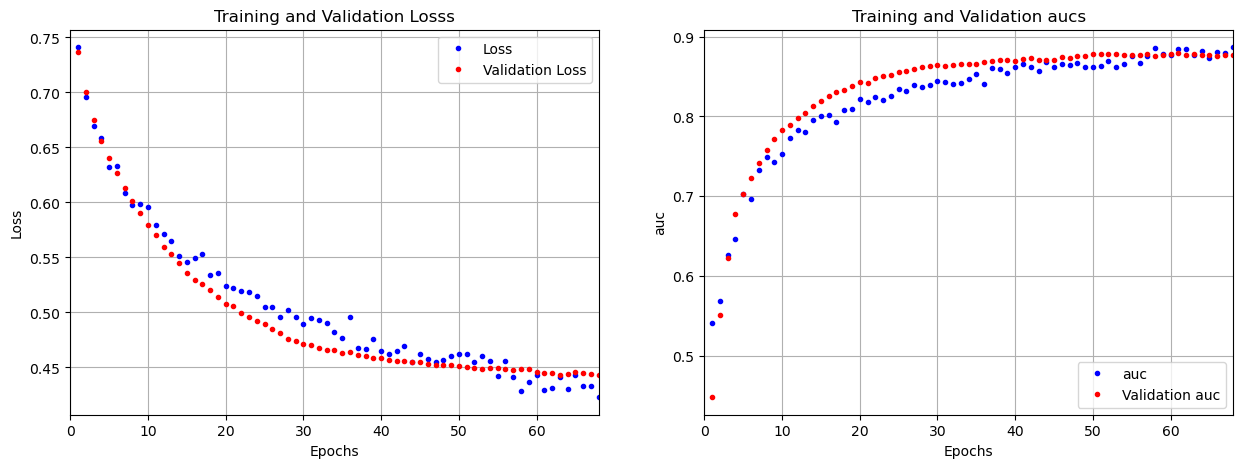

In [176]:
plot_training_history(trained_opt_model['history'], monitors=['loss', 'auc'])

In [183]:
print('Accuracy (Balanced Validation): {:.2f} (baseline=0.5)'.format(trained_opt_model['val_score'][0]))
print('Precision (Balanced Validation): {:.2f}'.format(trained_opt_model['val_score'][1]))
print('Recall (Balanced Validation): {:.2f}'.format(trained_opt_model['val_score'][2]))
print('AUC (Balanced Validation): {:.2f}'.format(trained_opt_model['val_score'][3]))

Accuracy (Balanced Validation): 0.79 (baseline=0.5)
Precision (Balanced Validation): 0.80
Recall (Balanced Validation): 0.78
AUC (Balanced Validation): 0.88


In [184]:
preds = trained_opt_model['model'].predict(X_val, verbose=0)

print('Accuracy (Imbalanced Validation): {:.2f} (baseline=0.7)'.format(accuracy_score(y_val, (preds > 0.5).astype('int32'))))
print('Precision (Imbalanced Validation): {:.2f}'.format(precision_score(y_val, (preds > 0.5).astype('int32'))))
print('Recall (Imbalanced Validation): {:.2f}'.format(recall_score(y_val, (preds > 0.5).astype('int32'))))
print('AUC (Imbalanced Validation): {:.2f}'.format(roc_auc_score(y_val, preds)))
print('Balanced Accuracy (Imbalanced Validation): {:.2f} (baseline = 0.5)'.format(balanced_accuracy_score(y_val, (preds > 0.5).astype('int32'))))

Accuracy (Imbalanced Validation): 0.73 (baseline=0.7)
Precision (Imbalanced Validation): 0.54
Recall (Imbalanced Validation): 0.63
AUC (Imbalanced Validation): 0.74
Balanced Accuracy (Imbalanced Validation): 0.70 (baseline = 0.5)


In [185]:
preds = trained_opt_model['model'].predict(X_test, verbose=0)

print('Accuracy (Imbalanced Test): {:.2f} (baseline=0.7)'.format(accuracy_score(y_test, (preds > 0.5).astype('int32'))))
print('Precision (Imbalanced Test): {:.2f}'.format(precision_score(y_test, (preds > 0.5).astype('int32'))))
print('Recall (Imbalanced Test): {:.2f}'.format(recall_score(y_test, (preds > 0.5).astype('int32'))))
print('AUC (Imbalanced Test): {:.2f}'.format(roc_auc_score(y_test, preds)))

Accuracy (Imbalanced Test): 0.73 (baseline=0.7)
Precision (Imbalanced Test): 0.54
Recall (Imbalanced Test): 0.70
AUC (Imbalanced Test): 0.79


In [186]:
print('Balanced Accuracy (Imbalanced Test): {:.2f} (baseline = 0.5)'.format(balanced_accuracy_score(y_test, 
                                                                                         (preds > 0.5).astype('int32'))))

Balanced Accuracy (Imbalanced Test): 0.72 (baseline = 0.5)


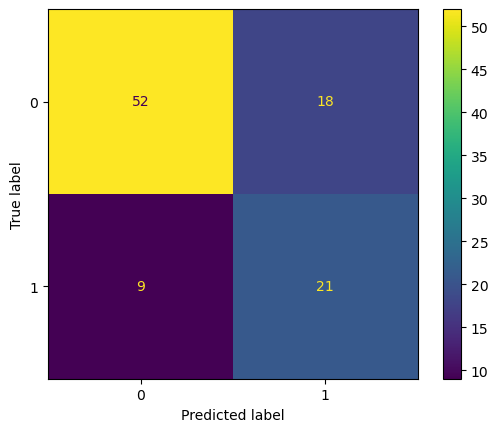

In [187]:
disp = ConfusionMatrixDisplay( confusion_matrix(y_test, (preds > 0.5).astype('int32')))
_ = disp.plot()